### Gumbel Quantizers (GQ)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[1.12.0.dev20220519]


### Define GQ class

In [2]:
def np2torch(x_np,device='cpu'):
    """ Numpy tensor to Torch tensor """
    return torch.tensor(x_np,dtype=torch.float32,device=device)
def torch2np(x_torch):
    """ Torch tensor to Numpy tensor """
    return x_torch.detach().cpu().numpy()
print ("Done.")

Done.


In [7]:
class GumbelQuantizerClass(nn.Module):
    """
        Gumbel Quantizer Class
    """
    def __init__(self,name='GQ',K=10,z_dim=5,e_dim=2,
                 e_min=-1.0,e_max=1.0,beta=1.0,
                 codebook_weight_np=None,
                 FREEZE_CODEBOOK=True):
        """
            Initialize GQ
        """
        super(GumbelQuantizerClass,self).__init__()
        self.name  = name
        self.K     = K     # number of codebook
        self.z_dim = z_dim # input (latent vector) dimension
        self.e_dim = e_dim # codebook dimension
        self.e_min = e_min
        self.e_max = e_max
        self.beta  = beta  # loss weight
        self.FREEZE_CODEBOOK = FREEZE_CODEBOOK
        # Initialize projection layer
        self.init_projection()    
        # Initialize codebook
        self.init_codebook()
        if codebook_weight_np is not None:
            self.codebook.weight.data = np2torch(codebook_weight_np)
    
    def init_projection(self):
        """
            Initialize projection layer
        """
        self.projection = nn.Linear(self.z_dim,self.K)
        nn.init.normal_(self.projection.weight,mean=0.0,std=0.1)
        nn.init.zeros_(self.projection.bias)
        
    def init_codebook(self):
        """
            Initialize codebook
        """
        self.codebook = nn.Embedding(self.K,embedding_dim=self.e_dim) # [K x e_dim]
        self.codebook.weight.data.uniform_(self.e_min,self.e_max)
        
    def forward(self,z,tau=1.0,USE_GUMBEL=True,ONEHOT=False,ARGMAX=False):
        """
            Forward
            z          : latent vector [B x z_dim]
            tau        : temperature
            USE_GUMBEL : use 'Gumbel Softmax' (True) or 'Softmax' (False)
            ONEHOT     : one hot vector
            ARGMAX     : use 'ArgMax'
            - Note that when using 'Softmax' or 'ArgMax', learning is not possible
        """
        logits = self.projection(z) # [B x K]
        codebook_weight = self.codebook.weight
        if ARGMAX:
            codebook_probs = F.one_hot(torch.argmax(logits,dim=1),num_classes=self.K) # [B x K]
            codebook_probs = codebook_probs.type(torch.float)
        else:
            if USE_GUMBEL: # use gumbel softmax (reparametrization or straight-through)
                codebook_probs = F.gumbel_softmax(logits=logits/tau,tau=tau,dim=1,hard=ONEHOT) # [B x K]
            else:
                codebook_probs = F.softmax(logits/tau,dim=1) # [B x K]
                if ONEHOT: # sample from categorical
                    C = torch.distributions.Categorical(probs=codebook_probs)
                    codebook_probs = F.one_hot(C.sample(),num_classes=self.K) # [B x K]
                    codebook_probs = codebook_probs.type(torch.float)
        if self.FREEZE_CODEBOOK:
            e = torch.matmul(codebook_probs,codebook_weight.detach()) # [B x E]
        else: 
            e = torch.matmul(codebook_probs,codebook_weight) # [B x E]
        # Loss
        codebook_probs; # [B x K]
        avg_codebook_probs = torch.mean(codebook_probs,dim=0) # [K]
        utilization_loss = self.beta * torch.sum(
            avg_codebook_probs * torch.log(avg_codebook_probs + 1e-6)) # [1]
        out  = {'codebook_weight':self.codebook.weight,'logits':logits,'e':e,
                'codebook_probs':codebook_probs,'avg_codebook_probs':avg_codebook_probs,
                'utilization_loss':utilization_loss}
        return out
print ("Ready.")

Done.


In [8]:
K     = 5 # number of codes
z_dim = 2 # latent dimension
e_dim = 5 # code dimension
codebook_weight_np = np.eye(5,5) # manually fix codebook
GQ = GumbelQuantizerClass(name='GQ',K=K,z_dim=z_dim,e_dim=e_dim,
                          codebook_weight_np=codebook_weight_np,
                          FREEZE_CODEBOOK=True)

In [9]:
GQ.codebook.weight

Parameter containing:
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], requires_grad=True)

### Forward path

In [10]:
n_batch = 3
tau     = 0.1 # temperature 
z       = np2torch(np.random.rand(n_batch,GQ.z_dim)) # [B x z_dim]
out_gumbel_soft    = GQ.forward(z=z,tau=tau,USE_GUMBEL=True,ONEHOT=False,ARGMAX=False)
out_gumbel_onehot  = GQ.forward(z=z,tau=tau,USE_GUMBEL=True,ONEHOT=True,ARGMAX=False)
out_softmax_soft   = GQ.forward(z=z,tau=tau,USE_GUMBEL=False,ONEHOT=False,ARGMAX=False)
out_softmax_onehot = GQ.forward(z=z,tau=tau,USE_GUMBEL=False,ONEHOT=True,ARGMAX=False)
out_argmax         = GQ.forward(z=z,tau=tau,ARGMAX=True)
print ("Done.")

Done.


### Plot `codebook probabilities`

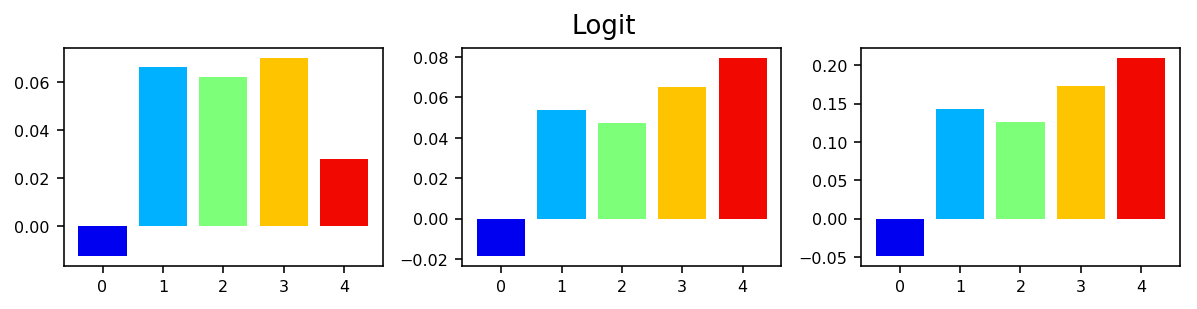

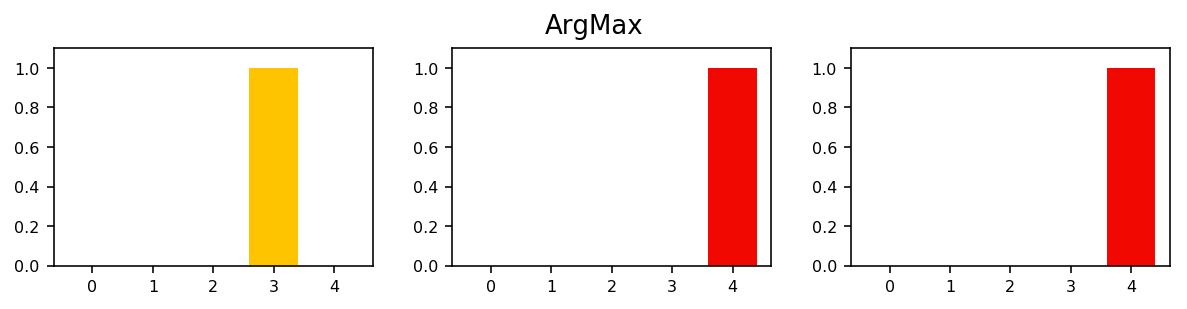

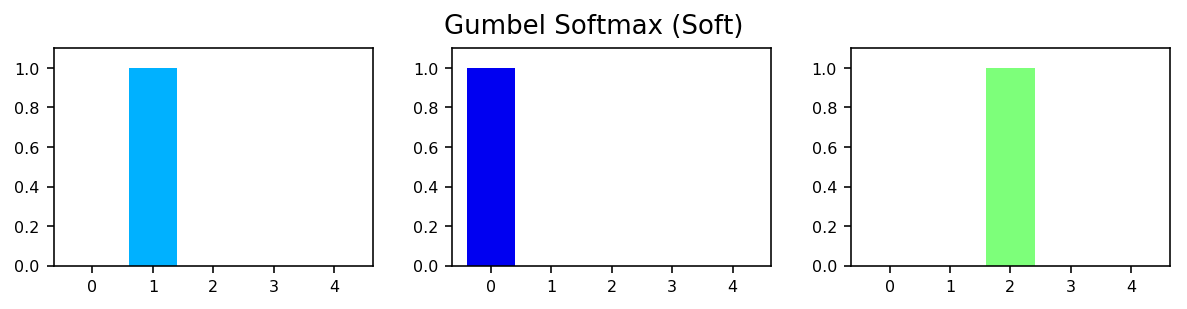

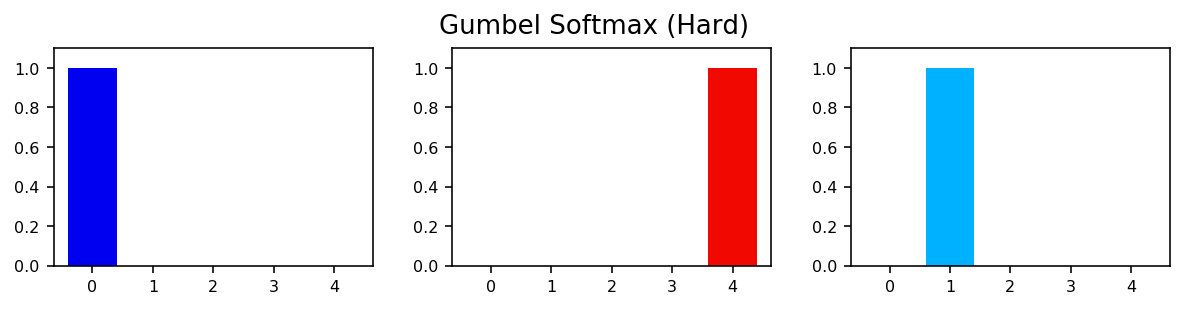

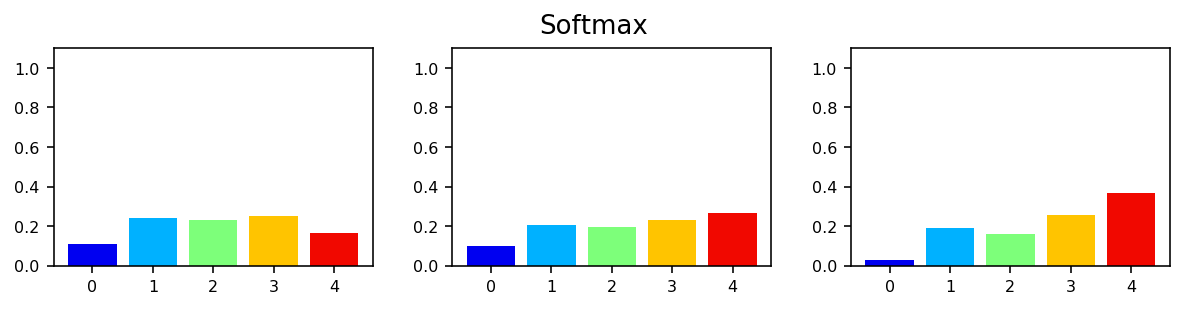

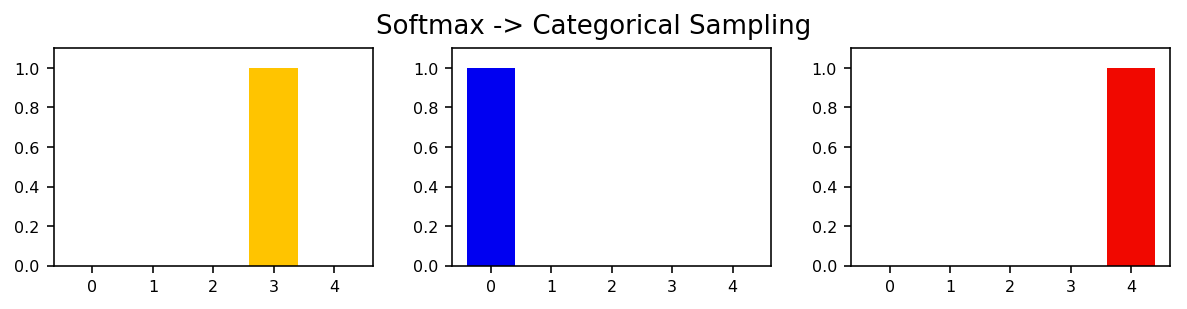

In [11]:
bar_colors = cm.get_cmap('jet')(np.linspace(0.1,0.9,GQ.K)) # [K]
# Plot logits
fig = plt.figure(figsize=(10,2))
plt.rcParams.update({'font.size':8}) # smaller fontsize (once is enough)
plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.K),
            torch2np(out_gumbel_soft['logits'][b_idx,:].squeeze()),
            color=bar_colors)
plt.suptitle('Logit',fontsize=13,y=1.0)
plt.show()
# Plot argmax 
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.K),
            torch2np(out_argmax['codebook_probs'][b_idx,:].squeeze()),
            color=bar_colors); plt.ylim([0,1.1])
plt.suptitle('ArgMax',fontsize=13,y=1.0)
plt.show()
# Plot gumbel + soft
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.K),
            torch2np(out_gumbel_soft['codebook_probs'][b_idx,:].squeeze()),
            color=bar_colors); plt.ylim([0,1.1])
plt.suptitle('Gumbel Softmax (Soft)',fontsize=13,y=1.0)
plt.show()
# Plot gumbel + hard
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.K),
            torch2np(out_gumbel_onehot['codebook_probs'][b_idx,:].squeeze()),
            color=bar_colors); plt.ylim([0,1.1])
plt.suptitle('Gumbel Softmax (Hard)',fontsize=13,y=1.0)
plt.show()
# Plot softmax + soft
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.K),
            torch2np(out_softmax_soft['codebook_probs'][b_idx,:].squeeze()),
            color=bar_colors); plt.ylim([0,1.1])
plt.suptitle('Softmax',fontsize=13,y=1.0)
plt.show()
# Plot softmax + hard
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.K),
            torch2np(out_softmax_onehot['codebook_probs'][b_idx,:].squeeze()),
            color=bar_colors); plt.ylim([0,1.1])
plt.suptitle('Softmax -> Categorical Sampling',fontsize=13,y=1.0)
plt.show()

### Plot `embedding` vectors

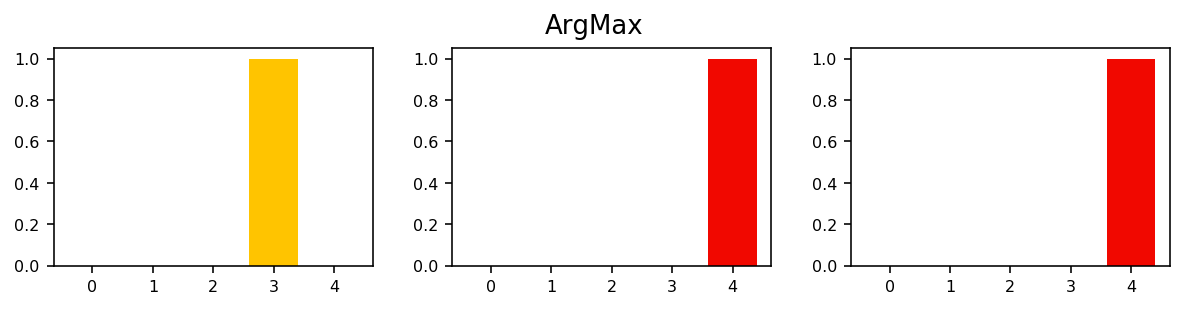

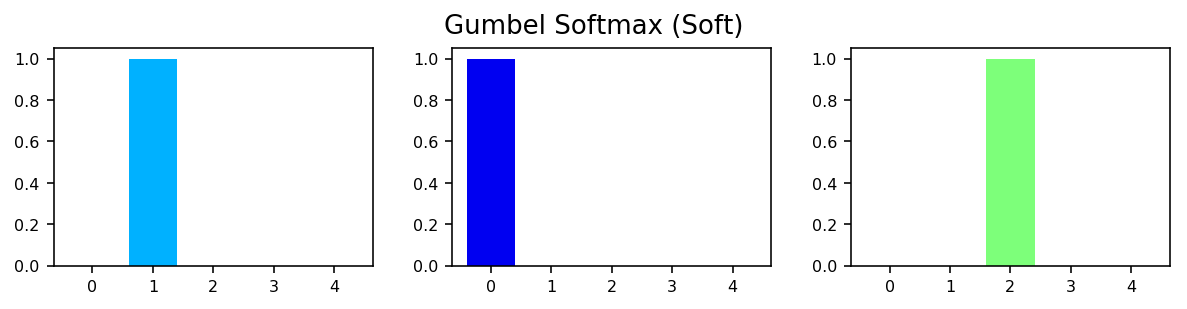

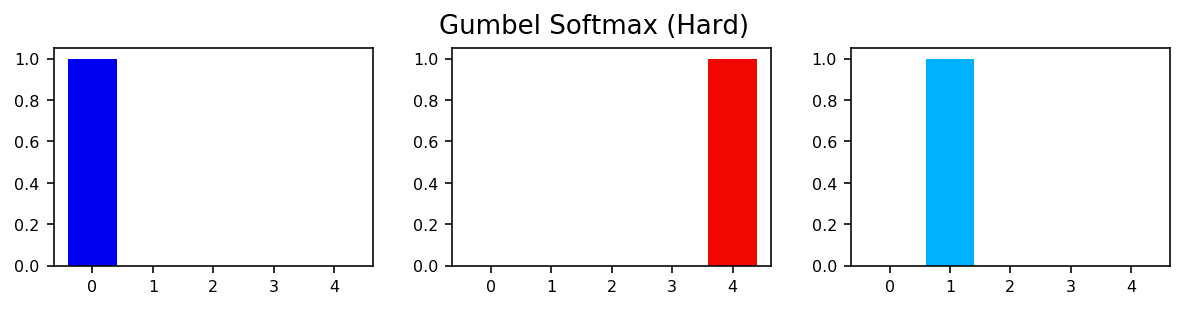

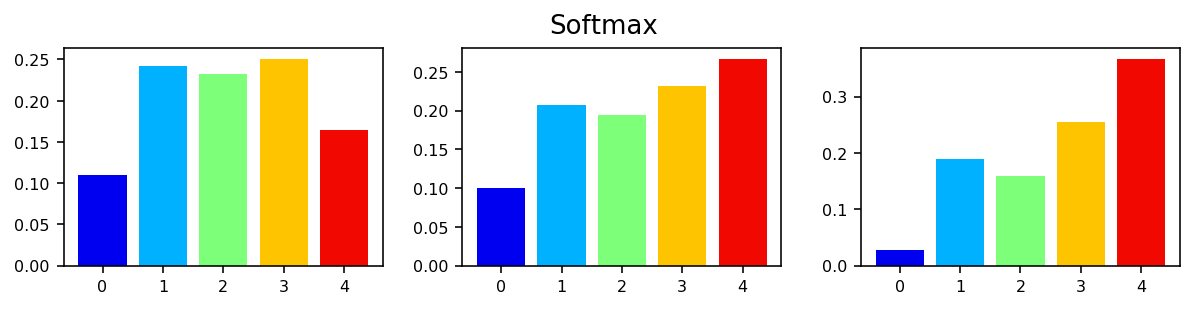

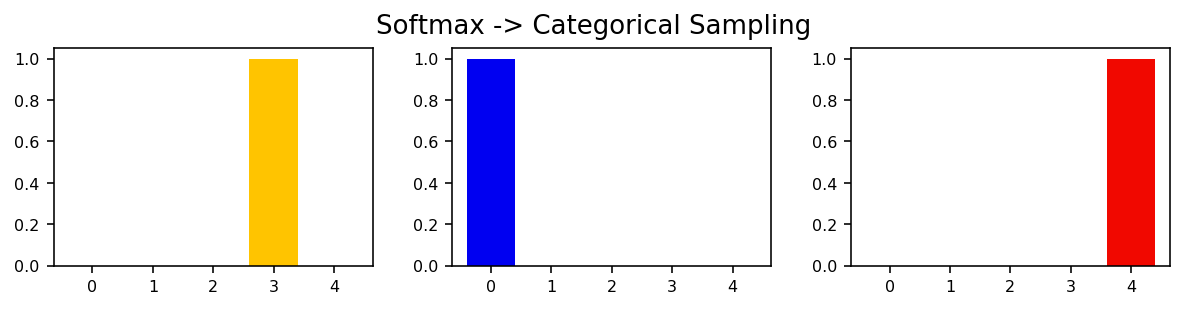

In [12]:
bar_colors = cm.get_cmap('jet')(np.linspace(0.1,0.9,GQ.e_dim)) # [e_dim]
# Plot argmax
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.e_dim),
            torch2np(out_argmax['e'][b_idx,:].squeeze()),
            color=bar_colors); # plt.ylim([0,1.1])
plt.suptitle('ArgMax',fontsize=13,y=1.0)
plt.show()
# Plot gumbel + soft
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.e_dim),
            torch2np(out_gumbel_soft['e'][b_idx,:].squeeze()),
            color=bar_colors); # plt.ylim([0,1.1])
plt.suptitle('Gumbel Softmax (Soft)',fontsize=13,y=1.0)
plt.show()
# Plot gumbel + hard
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.e_dim),
            torch2np(out_gumbel_onehot['e'][b_idx,:].squeeze()),
            color=bar_colors); # plt.ylim([0,1.1])
plt.suptitle('Gumbel Softmax (Hard)',fontsize=13,y=1.0)
plt.show()
# Plot softmax + soft
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.e_dim),
            torch2np(out_softmax_soft['e'][b_idx,:].squeeze()),
            color=bar_colors); # plt.ylim([0,1.1])
plt.suptitle('Softmax',fontsize=13,y=1.0)
plt.show()
# Plot softmax + hard
fig = plt.figure(figsize=(10,2));plt.subplots_adjust(wspace=0.25,hspace=0.05)
for b_idx in range(n_batch):
    plt.subplot(1,n_batch,b_idx+1)
    plt.bar(np.arange(GQ.e_dim),
            torch2np(out_softmax_onehot['e'][b_idx,:].squeeze()),
            color=bar_colors); # plt.ylim([0,1.1])
plt.suptitle('Softmax -> Categorical Sampling',fontsize=13,y=1.0)
plt.show()

### Check `embedding` vectors

In [13]:
out_gumbel_soft['e']

tensor([[2.3917e-13, 1.0000e+00, 1.2961e-16, 3.9355e-13, 1.9841e-15],
        [9.9999e-01, 1.1985e-05, 3.3672e-12, 1.7873e-07, 1.1567e-10],
        [1.5497e-24, 1.3812e-19, 1.0000e+00, 4.9410e-23, 7.5857e-14]],
       grad_fn=<MmBackward0>)

In [14]:
out_gumbel_onehot['e']

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]], grad_fn=<MmBackward0>)

In [15]:
out_softmax_soft['e']

tensor([[0.1100, 0.2416, 0.2323, 0.2512, 0.1649],
        [0.1005, 0.2071, 0.1939, 0.2313, 0.2672],
        [0.0279, 0.1901, 0.1598, 0.2545, 0.3677]], grad_fn=<MmBackward0>)

In [16]:
out_softmax_onehot['e']

tensor([[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])

In [17]:
out_argmax['e']

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])

```
    `out_gumbel_soft`, `out_gumbel_onehot`, and `out_softmax_soft` are differentiable.
    However, `out_softmax_onehot` and `out_argmax` are NOT differentiable. 
```